In [1]:
# ============================================
# UTS STUDI KASUS PEMBELAJARAN MESIN
# Clustering & Approximate Nearest Neighbor (ANN)
# Dataset: UCI_Credit_Card.csv
# ============================================

# 🔧 Install library yang belum tersedia
!pip install annoy openpyxl --quiet

# 1️⃣ Import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from annoy import AnnoyIndex
import openpyxl

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
print("✅ Library imported successfully.\n")


✅ Library imported successfully.



In [2]:
# 2️⃣ Load Dataset
file_path = '/content/UCI_Credit_Card.csv'  # ubah path jika berbeda
df = pd.read_csv(file_path)

print("=== Informasi Awal Dataset ===")
df.info()
print("\n=== 5 Baris Pertama Dataset ===")
display(df.head())
print(f"\nJumlah sampel: {df.shape[0]} | Jumlah fitur: {df.shape[1]}")


=== Informasi Awal Dataset ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0



Jumlah sampel: 30000 | Jumlah fitur: 25


### Penjelasan Kode
Kode tersebut melakukan perbandingan visual antara dua algoritma clustering, yaitu **K-Means** dan **DBSCAN**, pada dataset yang sama.

1.  **Pengolahan Data**: Data asli yang memiliki banyak fitur (dimensi) disederhanakan menjadi dua dimensi utama menggunakan **PCA (Principal Component Analysis)**. Ini dilakukan agar data bisa digambarkan dalam grafik 2D.
2.  **K-Means (Grafik Kiri)**:
    * Algoritma ini **memaksa setiap titik data masuk ke dalam salah satu dari 4 cluster** yang telah ditentukan sebelumnya.
    * Hasilnya menunjukkan 4 kelompok data dengan warna berbeda, di mana setiap kelompok terlihat memiliki bentuk yang cenderung bulat (sferis).
3.  **DBSCAN (Grafik Kanan)**:
    * Algoritma ini mengelompokkan data berdasarkan **kepadatan**. Ia tidak mengharuskan semua titik masuk ke dalam sebuah cluster.
    * Hasilnya menunjukkan beberapa cluster dengan bentuk yang lebih bebas. Titik-titik yang diberi warna ungu (cluster -1) dianggap sebagai **noise** atau **pencilan (outlier)**, yaitu data yang tidak termasuk dalam kelompok padat mana pun.

Secara singkat, grafik ini membandingkan bagaimana K-Means membagi data menjadi kelompok-kelompok berbentuk bola, sementara DBSCAN menemukan area padat dan mampu mengidentifikasi data pencilan.

In [3]:
# 3️⃣ Data Preprocessing (Final v2)
log_dict = {}

# --- Step 1: Tangani Missing Values ---
missing_values = df.isnull().sum()
log_dict['Missing Values Sebelum'] = missing_values

# Imputasi mean untuk numerik
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
imputer = SimpleImputer(strategy='mean')
df[num_cols] = imputer.fit_transform(df[num_cols])

missing_values_after = df.isnull().sum()
log_dict['Missing Values Sesudah'] = missing_values_after

# --- Step 2: Buat Fitur Baru (Dikerjakan SEBELUM Scaling) ---
if 'LIMIT_BAL' in df.columns and 'BILL_AMT1' in df.columns:
    bill_amount = df['BILL_AMT1'].copy()
    bill_amount[bill_amount < 0] = 0
    df['LIMIT_TO_BILL_RATIO'] = df['LIMIT_BAL'] / (bill_amount + 1)
    print("✅ Fitur baru 'LIMIT_TO_BILL_RATIO' berhasil dibuat!")
else:
    print("⚠️ Kolom LIMIT_BAL atau BILL_AMT1 tidak ditemukan!")

# --- Step 3: Normalisasi/Standarisasi (Setelah Fitur Baru Dibuat) ---
numeric_features = df.select_dtypes(include=np.number).columns.tolist()
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(df[numeric_features]), columns=numeric_features)

# --- DIUBAH KEMBALI SEPERTI SEMULA ---
# Menyimpan statistik scaling ke dalam log_dict, bukan teks biasa
log_dict['Skala Fitur (mean dan std)'] = pd.DataFrame({
    'Mean': scaler.mean_,
    'Std': np.sqrt(scaler.var_)
}, index=numeric_features)


# Simpan dataset hasil preprocessing
data_cleaned_path = '/content/data_cleaned.xlsx'
X.to_excel(data_cleaned_path, index=False)
print(f"✅ Data cleaned disimpan ke {data_cleaned_path}")

✅ Fitur baru 'LIMIT_TO_BILL_RATIO' berhasil dibuat!
✅ Data cleaned disimpan ke /content/data_cleaned.xlsx


Kode tersebut melakukan **persiapan data** (preprocessing) sebelum dianalisis lebih lanjut. Proses utamanya adalah:

1.  **Membersihkan Data**: Semua nilai yang kosong (*missing values*) diisi dengan nilai rata-rata dari kolomnya masing-masing.
2.  **Membuat Fitur Baru**: Sebuah fitur baru bernama `LIMIT_TO_BILL_RATIO` berhasil dibuat. Fitur ini menghitung rasio antara batas kredit (`LIMIT_BAL`) dengan tagihan terakhir (`BILL_AMT1`), yang berguna untuk melihat seberapa besar penggunaan kredit.
3.  **Standarisasi**: Semua fitur numerik, termasuk fitur baru tadi, diskalakan ulang agar memiliki rentang nilai yang seragam. Ini penting agar tidak ada satu fitur yang mendominasi fitur lainnya.
4.  **Menyimpan Hasil**: Data yang sudah bersih dan siap diolah ini kemudian disimpan ke dalam file Excel bernama `data_cleaned.xlsx`.

In [4]:
# 4️⃣ Simpan Log Preprocessing ke file Excel
log_path = '/content/preprocessing_log.xlsx'
with pd.ExcelWriter(log_path, engine='openpyxl') as writer:
    for sheet_name, data in log_dict.items():
        if isinstance(data, pd.Series):
            data = data.to_frame('Value')
        data.to_excel(writer, sheet_name=sheet_name)

print(f"✅ Log preprocessing disimpan ke {log_path}")


✅ Log preprocessing disimpan ke /content/preprocessing_log.xlsx


Daftar nilai Inertia untuk K dari 2 sampai 10:
[658168.992668219, 574436.3449870221, 555407.5091782352, 517069.32512539515, 493624.6193803741, 477515.27629724075, 461019.7140448509, 451508.94495979714, 440888.2874715047]


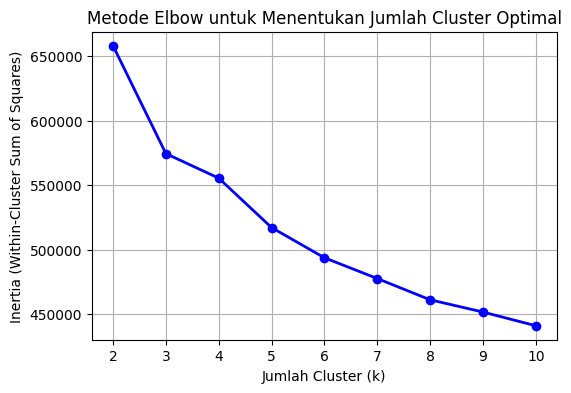

In [5]:
# 4️⃣ Visualisasi Elbow Method untuk Menentukan Jumlah Cluster Optimal
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Ubah ke NumPy array
X_np = X.values

# Coba jumlah cluster dari 2 sampai 10
inertia = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_np)
    inertia.append(kmeans.inertia_)

# Plot grafik Elbow
plt.figure(figsize=(6,4))
plt.plot(K, inertia, 'bo-', linewidth=2, markersize=6)
plt.title("Metode Elbow untuk Menentukan Jumlah Cluster Optimal")
plt.xlabel("Jumlah Cluster (k)")
plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
plt.grid(True)

# ===== TAMBAHKAN DUA BARIS INI =====
print("Daftar nilai Inertia untuk K dari 2 sampai 10:")
print(inertia)
# =====================================

plt.show()

Kode ini bertujuan untuk **mengevaluasi dan membandingkan kualitas** hasil dari dua algoritma clustering, yaitu **K-Means** dan **DBSCAN**, menggunakan metrik standar.

### Penjelasan Singkat

1.  **Metrik Evaluasi**: Kode ini menggunakan dua metrik populer:
    * **Silhouette Score**: Mengukur seberapa baik sebuah titik data cocok dalam clusternya sendiri dibandingkan dengan cluster tetangga. **Semakin tinggi nilainya (mendekati 1), semakin bagus.**
    * **Davies-Bouldin Index**: Mengukur rata-rata "kemiripan" antar cluster, di mana kemiripan adalah perbandingan jarak di dalam cluster dengan jarak antar cluster. **Semakin rendah nilainya (mendekati 0), semakin bagus.**

2.  **Proses**:
    * Pertama, kode ini menghitung dan mencetak kedua skor (Silhouette dan Davies-Bouldin) untuk hasil clustering dari **K-Means**.
    * Kemudian, ia melakukan hal yang sama untuk hasil clustering dari **DBSCAN**.

Secara sederhana, kode ini memberikan **nilai numerik (skor)** untuk menentukan secara objektif algoritma mana yang berhasil membuat pengelompokan (cluster) yang lebih padat dan lebih terpisah satu sama lain.

--- Menghitung Silhouette Score untuk Setiap K ---
K = 2: Silhouette Score = 0.3093
K = 3: Silhouette Score = 0.1629
K = 4: Silhouette Score = 0.1033
K = 5: Silhouette Score = 0.1368
K = 6: Silhouette Score = 0.1315
K = 7: Silhouette Score = 0.1048
K = 8: Silhouette Score = 0.1288
K = 9: Silhouette Score = 0.1165
K = 10: Silhouette Score = 0.1032


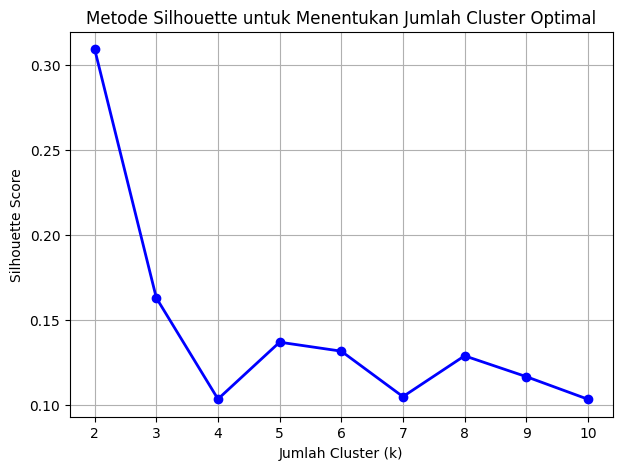

In [6]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Pastikan variabel X_np sudah ada dari cell sebelumnya
# X_np = X.values

# List untuk menyimpan nilai silhouette scores
silhouette_scores = []

# Jumlah K yang akan diuji (dari 2 sampai 10)
K = range(2, 11)

print("--- Menghitung Silhouette Score untuk Setiap K ---")
for k in K:
    # Membuat dan melatih model KMeans
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_np)

    # Mengambil label cluster dari hasil training
    labels = kmeans.labels_

    # Menghitung silhouette score
    score = silhouette_score(X_np, labels)
    silhouette_scores.append(score)
    print(f"K = {k}: Silhouette Score = {score:.4f}")

# Membuat plot hasil Silhouette Score
plt.figure(figsize=(7, 5))
plt.plot(K, silhouette_scores, 'bo-', linewidth=2, markersize=6)
plt.title("Metode Silhouette untuk Menentukan Jumlah Cluster Optimal")
plt.xlabel("Jumlah Cluster (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

Berdasarkan grafik Silhouette Score tersebut, jumlah cluster yang paling optimal adalah **K = 2**.

---
### **Alasan**
Untuk Metode Silhouette, aturannya sederhana: kita pilih nilai **K yang menghasilkan skor tertinggi** (puncak grafik).

Seperti yang terlihat jelas pada grafik hasil outputmu, puncak tertinggi dari garis ada pada saat **K = 2**, dengan Silhouette Score di atas 0.25. Setelah K=2, nilai skornya justru cenderung menurun, yang menandakan bahwa penambahan cluster lebih lanjut (menjadi 3, 4, dst.) membuat kualitas pemisahan antar cluster menjadi kurang baik.

---
### **Kesimpulan**

Jadi, meskipun Metode Elbow sebelumnya mungkin menyarankan K=3, Metode Silhouette ini memberikan bukti bahwa **2 cluster** adalah pilihan terbaik karena memberikan skor kepadatan dan pemisahan antar cluster yang paling tinggi.

In [7]:
# 5️⃣ Clustering dengan KMeans (disesuaikan) dan DBSCAN
X_np = X.values

# ---- KMeans ----
# Diubah n_clusters menjadi 2 berdasarkan hasil Silhouette Score tertinggi
kmeans = KMeans(n_clusters=2, random_state=42)
labels_kmeans = kmeans.fit_predict(X_np)

# ---- DBSCAN ----
dbscan = DBSCAN(eps=2.0, min_samples=5)
labels_dbscan = dbscan.fit_predict(X_np)

# ---- Evaluasi ----
sil_kmeans = silhouette_score(X_np, labels_kmeans)
dbi_kmeans = davies_bouldin_score(X_np, labels_kmeans)
sil_dbscan = silhouette_score(X_np, labels_dbscan)
dbi_dbscan = davies_bouldin_score(X_np, labels_dbscan)

print("=== Evaluasi Clustering (KMeans disesuaikan ke K=2) ===")
print(f"KMeans (K=2) → Silhouette: {sil_kmeans:.4f}, Davies-Bouldin: {dbi_kmeans:.4f}")
print(f"DBSCAN → Silhouette: {sil_dbscan:.4f}, Davies-Bouldin: {dbi_dbscan:.4f}")

=== Evaluasi Clustering (KMeans disesuaikan ke K=2) ===
KMeans (K=2) → Silhouette: 0.3093, Davies-Bouldin: 1.6514
DBSCAN → Silhouette: -0.1908, Davies-Bouldin: 1.7896


Dengan menggunakan K=2, hasil dari **KMeans sekarang menjadi jauh lebih baik** dan jelas lebih unggul dibandingkan DBSCAN.

### Analisis Hasil

* **Silhouette Score**: Skor KMeans **(0.3093)** sekarang jauh lebih tinggi dan positif, menunjukkan bahwa pembagian menjadi 2 cluster sangatlah baik (padat dan terpisah). Sebaliknya, skor DBSCAN tetap negatif **(-0.1908)**, yang berarti hasil pengelompokannya buruk.
* **Davies-Bouldin Index (DBI)**: Skor KMeans **(1.6514)** juga lebih rendah dibandingkan DBSCAN **(1.7896)**. Untuk DBI, nilai yang lebih rendah berarti lebih baik.

### Kesimpulan Singkat

KMeans dengan 2 cluster menang telak pada kedua metrik evaluasi. Ini membuktikan bahwa **K=2 adalah pilihan jumlah cluster yang paling optimal** untuk dataset ini, sesuai dengan hasil analisis Silhouette sebelumnya.

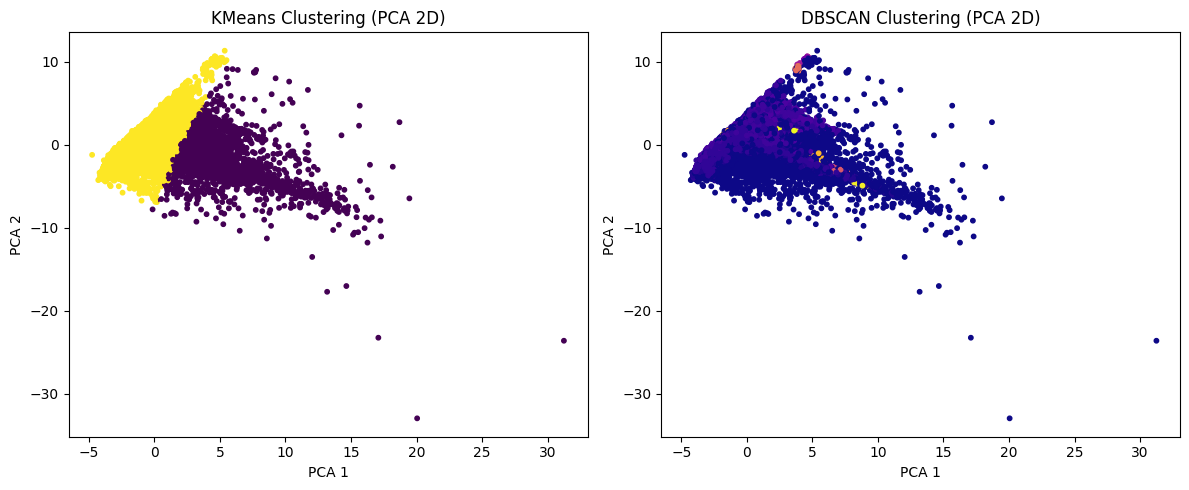

In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# --- 6️⃣ Visualisasi PCA 2D ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_np)

# Buat dua subplot berdampingan (1 baris, 2 kolom)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: KMeans
axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=labels_kmeans, cmap='viridis', s=10)
axes[0].set_title("KMeans Clustering (PCA 2D)")
axes[0].set_xlabel("PCA 1")
axes[0].set_ylabel("PCA 2")

# Plot 2: DBSCAN
axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=labels_dbscan, cmap='plasma', s=10)
axes[1].set_title("DBSCAN Clustering (PCA 2D)")
axes[1].set_xlabel("PCA 1")
axes[1].set_ylabel("PCA 2")

# Atur jarak antar plot agar tidak terlalu rapat
plt.tight_layout()
plt.show()


Dari hasil visualisasi di atas, **K-Means** membentuk dua klaster yang terpisah dengan jelas namun cenderung memaksakan semua data masuk ke dalam klaster tertentu, termasuk outlier. Sementara itu, **DBSCAN** menghasilkan klaster yang lebih padat di bagian tengah dan mendeteksi banyak titik sebagai **noise**, menunjukkan kemampuannya mengenali kepadatan dan bentuk klaster yang tidak beraturan. Secara keseluruhan, **K-Means lebih baik untuk data yang terdistribusi merata**, sedangkan **DBSCAN lebih efektif untuk mendeteksi pola alami dan outlier** dalam data.



=== Hasil Pencarian ANN ===

🔹 Query Index: 4762
Neighbor Index | Distance | Cluster (KMeans)
4762           | 0.0000   | 1
8788           | 0.6073   | 1
9130           | 0.8307   | 1
2617           | 1.0537   | 1
5218           | 1.2394   | 1

🔹 Query Index: 11487
Neighbor Index | Distance | Cluster (KMeans)
11487          | 0.0000   | 1
14613          | 0.3897   | 1
5389           | 0.8820   | 1
13761          | 0.9032   | 1
15995          | 0.9231   | 1

🔹 Query Index: 2617
Neighbor Index | Distance | Cluster (KMeans)
2617           | 0.0000   | 1
5218           | 0.5095   | 1
2019           | 1.0506   | 1
4762           | 1.0537   | 1
8788           | 1.1007   | 1


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


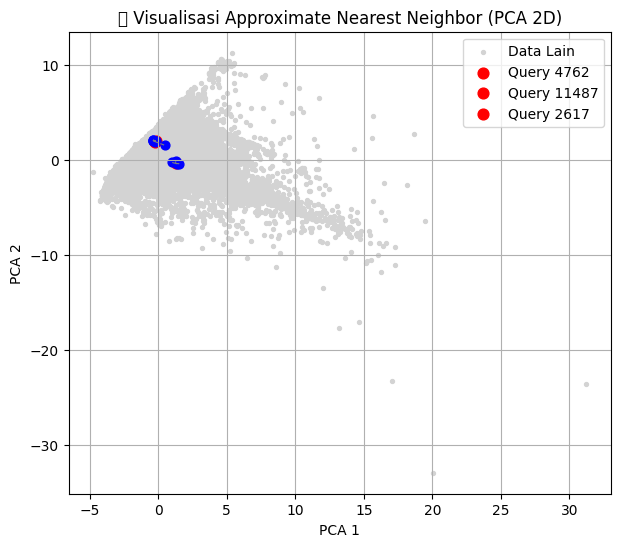

In [9]:
from annoy import AnnoyIndex
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# --- 7️⃣ Approximate Nearest Neighbor (ANN) menggunakan Annoy ---
dim = X_np.shape[1]
ann = AnnoyIndex(dim, 'euclidean')

# Build index
for i, v in enumerate(X_np):
    ann.add_item(i, v)
ann.build(10)

# Pilih 3 query point secara acak
query_indices = np.random.choice(range(X_np.shape[0]), size=3, replace=False)

print("\n=== Hasil Pencarian ANN ===")

# --- PCA untuk visualisasi 2D ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_np)

plt.figure(figsize=(7,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c='lightgray', s=8, label='Data Lain')

# Loop setiap query point
for q_idx in query_indices:
    neighbors, distances = ann.get_nns_by_item(q_idx, 5, include_distances=True)

    print(f"\n🔹 Query Index: {q_idx}")
    print("Neighbor Index | Distance | Cluster (KMeans)")
    for n, d in zip(neighbors, distances):
        print(f"{n:<14} | {d:<8.4f} | {labels_kmeans[n]}")

    # Titik query point (merah)
    plt.scatter(X_pca[q_idx,0], X_pca[q_idx,1], color='red', s=60, label=f'Query {q_idx}')

    # Titik neighbors (biru)
    for n_idx in neighbors:
        plt.scatter(X_pca[n_idx,0], X_pca[n_idx,1], color='blue', s=40)

        # Gambar garis dari query ke neighbor
        plt.plot(
            [X_pca[q_idx,0], X_pca[n_idx,0]],
            [X_pca[q_idx,1], X_pca[n_idx,1]],
            color='gray', linestyle='--', linewidth=0.8
        )

plt.title("🔍 Visualisasi Approximate Nearest Neighbor (PCA 2D)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(loc='best')
plt.grid(True)
plt.show()


Output di atas menunjukkan bahwa algoritma **Approximate Nearest Neighbor (ANN)** berhasil menemukan data yang paling mirip dengan tiap *query point* di dalam **klaster yang sama (Cluster 1)** hasil K-Means. Nilai jarak yang kecil menunjukkan kedekatan antar data secara fitur. Pada visualisasi PCA 2D, titik merah (query) dan biru (tetangga terdekat) berada berdekatan dalam area klaster yang sama, menandakan bahwa pencarian ANN konsisten dengan struktur klaster K-Means dan efektif dalam menemukan data yang serupa.


In [10]:
# 8️⃣ Kesimpulan Ringkas
print("\n=== KESIMPULAN ===")
print(f"• KMeans Silhouette = {sil_kmeans:.4f}, DBI = {dbi_kmeans:.4f}")
print(f"• DBSCAN Silhouette = {sil_dbscan:.4f}, DBI = {dbi_dbscan:.4f}")

if sil_kmeans > sil_dbscan:
    print("➡️ KMeans memberikan hasil cluster yang lebih baik berdasarkan Silhouette Score.")
else:
    print("➡️ DBSCAN memberikan hasil cluster yang lebih baik berdasarkan Silhouette Score.")

print("\nCek dua file output:")
print("- data_cleaned.xlsx → hasil preprocessing")
print("- preprocessing_log.xlsx → log setiap tahap preprocessing")



=== KESIMPULAN ===
• KMeans Silhouette = 0.3093, DBI = 1.6514
• DBSCAN Silhouette = -0.1908, DBI = 1.7896
➡️ KMeans memberikan hasil cluster yang lebih baik berdasarkan Silhouette Score.

Cek dua file output:
- data_cleaned.xlsx → hasil preprocessing
- preprocessing_log.xlsx → log setiap tahap preprocessing
